In [1]:
import numpy as np
import gpstk
from GNSS_TK import *
import matplotlib.pyplot as plt
%matplotlib inline

Funciones

In [ ]:
def get_arcs(t,Icode,Iphase,ELEV,IPPS): #returns arcs with observations time, phase & code delay,IPP
    Phase=[]
    Code=[]
    Elevetion=[]
    for i in t:
        Phase.append(Iphase[i])
        Code.append(Icode[i])
        Elevetion.append(ELEV[i])
        
    t=adjust_times(t)
    Phase,Code,t,Elevetion=np.array(Phase),np.array(Code),np.array(t),np.array(Elevetion)
    
    ant=0
    limits=[]
    for i in range(1,len(t)):
        if t[i]-t[i-1]>1800: #si hay mas de 2 horas entre una observacion y la otra es que ya es otro arco
            limits.append(i)

    arcs=np.split(range(t.size),limits)
    obs={} #Key: Number if arc, Values: time of observations and Phase Delays
    i=0
    for arc in arcs:
        obs[i]=[t[arc],Phase[arc],Code[arc],Elevetion[arc]]
        i+=1
    return obs

In [ ]:
def adjust_times(t): #sync station times, returns times in common and difference
    np.array(t)
    for i in range(len(t)):
        if t[i]%30!=0:
            t[i]=t[i]+(30-t[i]%30)
    return t

In [2]:
stations=[[["data/zob1324.03.n","data/zob13240.03o"],["data/garf324.03.n","data/garf3240.03o"]],[["data/woos324.03.n","data/woos324.03.o"],["data/garf324.03.n","data/garf3240.03o"]]]

Station 1: ['data/zob1324.03.n', 'data/zob13240.03o']

Station 2: ['data/garf324.03.n', 'data/garf3240.03o']

Times in common:  108

Data Jumps st1:  []
[]

Data Jumps st2:  [1] 


[ 5.71666667]
Divide in Sub-arcs using jumps

Remove short arcs
SubArc #  0
Sub-Arcs deleted 0 [0]
SubArc #  1

Deleted elements on the other station:  {0: [0]}

New # of subarcs arc1:  1

New # of subarcs of arc2 (other station):  1
# Observations st1:  107 107
# Observations st2:  107 107

Times in common:  632

Data Jumps st1:  [168 376 378]
[ 19.275       21.01666667  21.03333333]

Data Jumps st2:  [  1   3 168] 


[ 17.88333333  17.9         19.275     ]
Divide in Sub-arcs using jumps

Remove short arcs
SubArc #  0
SubArc #  1
SubArc #  2
Sub-Arcs deleted 2 [376 377]
SubArc #  3

Deleted elements on the other station:  {3: [208, 209]}

New # of subarcs arc1:  3

New # of subarcs of arc2 (other station):  4
SubArc #  0
Sub-Arcs deleted 0 [0]
SubArc #  1
Sub-Arcs deleted 1 [1 2]
SubArc #  2
SubArc #  3

D

/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


 0 Outlier factor:  0
Delete index:  168
# Observations st1:  626 626
# Observations st2:  626 626
Station 1: ['data/woos324.03.n', 'data/woos324.03.o']

Station 2: ['data/garf324.03.n', 'data/garf3240.03o']

Times in common:  82

Data Jumps st1:  [ 4  6 81]
[ 5.83333333  5.85833333  6.48333333]

Data Jumps st2:  [] 


[]
Divide in Sub-arcs using jumps

Remove short arcs
SubArc #  0
Sub-Arcs deleted 0 [0 1 2 3]
SubArc #  1
Sub-Arcs deleted 1 [4 5]
SubArc #  2
SubArc #  3
Sub-Arcs deleted 3 [81]

Deleted elements on the other station:  {0: [0, 1, 2, 3, 4, 5, 81]}

New # of subarcs arc1:  1

New # of subarcs of arc2 (other station):  1
# Observations st1:  75 75
# Observations st2:  75 75

Times in common:  637

Data Jumps st1:  [1]
[ 17.88333333]

Data Jumps st2:  [  1   3 168] 


[ 17.88333333  17.9         19.275     ]
Divide in Sub-arcs using jumps

Remove short arcs
SubArc #  0
Sub-Arcs deleted 0 [0]
SubArc #  1

Deleted elements on the other station:  {0: [0]}

New # of subarcs arc

/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


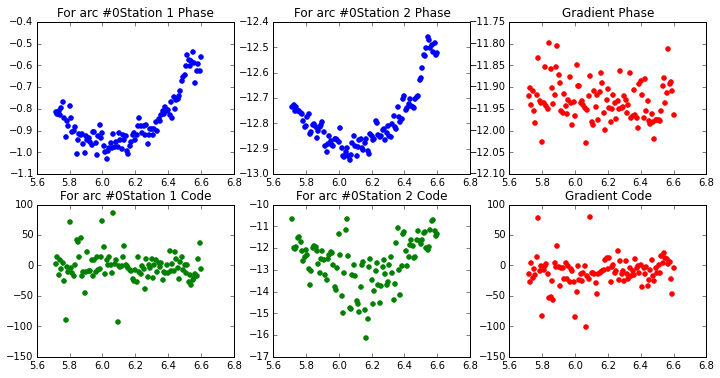

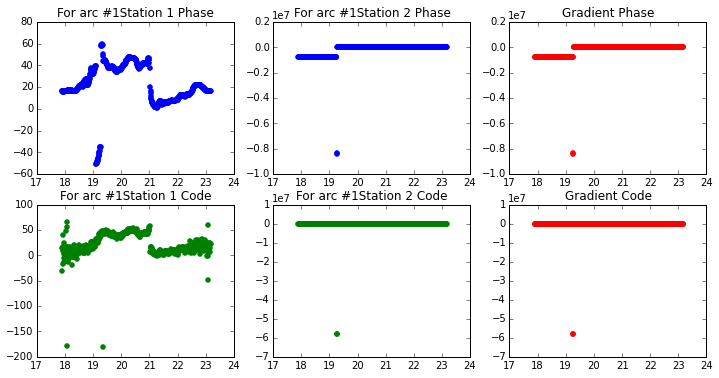

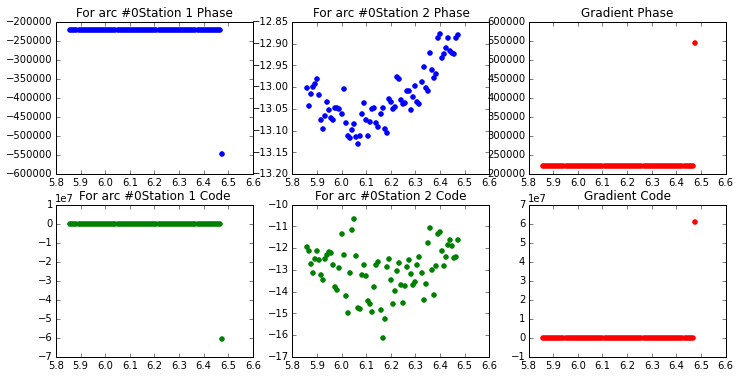

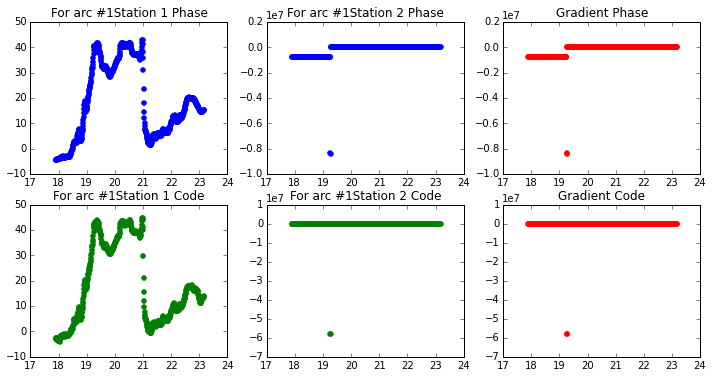

In [15]:
for pair in stations:
    st1=pair[0]
    st2=pair[1]
    print "Station 1:",st1
    print "\nStation 2:",st2
    t1,t2,Icode1,Iphase1,Icode2,Iphase2,VTECphase1,VTECphase2,ELEV1,ELEV2,IPP1,IPP2=getdata_stationpair(st1,st2,"GPS 8")
    obs1=get_arcs(t1,Icode1,Iphase1,ELEV1,IPP1) #gets Phase, Code, and adjusted times 
    obs2=get_arcs(t2,Icode2,Iphase2,ELEV2,IPP2)
    
    for arc in range(len(obs1)):#to each arc observed in a day
        time1=obs1[arc][0] #times on station 1 same arc!
        time2=obs2[arc][0] #times on station 2
        
        Phase1=obs1[arc][1]
        Phase2=obs2[arc][1]
        
       
        tboth=np.intersect1d(time1,time2)
        print "\nTimes in common: ",tboth.size
        
        #Now we take observations in both stations
        t1index=np.array([i for i in range(time1.size) if time1[i] in tboth ])
        t2index=np.array([i for i in range(time2.size) if time2[i] in tboth ])
        
        time1=time1[t1index] #times on station 1 same arc!
        time2=time2[t2index]
        
        Phase1=Phase1[t1index]
        Phase2=Phase2[t2index]
        
        Code1=obs1[arc][2][t1index]
        Code2=obs2[arc][2][t2index]
        
        Elevation1=obs1[arc][3][t1index]
        Elevation2=obs2[arc][3][t2index]
        
        #Detect data jumps
        jumps1=datajump(Phase1,time1,2.5)
        print "\nData Jumps st1: ",jumps1
        print time1[jumps1]/3600
        
        jumps2=datajump(Phase2,time2,2.5)
        print "\nData Jumps st2: ",jumps2,"\n\n"
        print time1[jumps2]/3600
        
        #Divide in Sub-arcs using jumps
        print "Divide in Sub-arcs using jumps"
        miniarcs1=sub_arcs(Phase1,jumps1)
        miniarcs2=sub_arcs(Phase2,jumps2)
        #print "\nSubarcs st1: ",miniarcs1
        #print "\nSubarcs st2: ",miniarcs2
        
        #Remove short arcs 
        print "\nRemove short arcs"
        if len(jumps1)!=0:
            miniarcs1,miniarcs2=remove_short(miniarcs1,miniarcs2)
        if len(jumps2)!=0:
            miniarcs2,miniarcs1=remove_short(miniarcs2,miniarcs1)
        
        #Polinomial fit and Outlier Detection
        ##On each subarc check for slips and delete.
        pslips1=[] #slips in st1 with polinomyal fit
        pslips2=[] #slips in st2 with polinomyal fit
        oslips1=[] #slips in st1 oulier factor
        oslips2=[] #slips in st2 oulier factor
        
        for i in range(len(miniarcs1)):#In station1
            __,pslip=poly_fit(Phase1[miniarcs1[i]],time1[miniarcs1[i]])
            pslips1.append(pslip)
            __,oslip=outlier_detect(Phase1[miniarcs1[i]],time1[miniarcs1[i]]*3600)
            oslips1.append(oslip)
        
        for i in range(len(miniarcs2)):#In station2
            __,pslip=poly_fit(Phase2[miniarcs2[i]],time2[miniarcs2[i]])
            pslips2.append(pslip)
            __,oslip=outlier_detect(Phase2[miniarcs2[i]],time2[miniarcs2[i]]*3600)
            oslips2.append(oslip)
        
        ##Using polinompyal fit and outlier factor methods we confirm slips
        confirmed1=[] #a list of lists with the confirmed outliers on each subarc
        confirmed2=[]
        
        for i in range(len(miniarcs1)):
            outliers=confirmed_slip(time1[miniarcs1[i]],Phase1[miniarcs1[i]],threshold=0.8)
            confirmed1.append(outliers)
            
        for i in range(len(miniarcs2)):
            outliers=confirmed_slip(time2[miniarcs2[i]],Phase2[miniarcs2[i]],threshold=0.8)
            confirmed2.append(outliers) 
            
        #Remove slips from both stations
        for i in range(len(confirmed1)):
            if len(confirmed1[i])!=0:
                miniarcs1[i],miniarcs2=remove_slip(miniarcs1[i],miniarcs2,oslips1[i])
        
        for i in range(len(confirmed2)):
            if len(confirmed2[i])!=0:
                miniarcs2[i],miniarcs1=remove_slip(miniarcs1[i],miniarcs1,oslips2[i])
        
        #Leveling Phase
        PhaseArc1=[]
        PhaseArc2=[]
        C1=[]
        C2=[]
        for i in range(len(miniarcs1)):
            Lfactor,new_IPHASE_arc=levelphase(Code1[miniarcs1[i]],Phase1[miniarcs1[i]],Elevation1[miniarcs1[i]])
            PhaseArc1.append(new_IPHASE_arc)   
            C1.append(Code1[miniarcs1[i]])
        
        for i in range(len(miniarcs2)):
            Lfactor,new_IPHASE_arc=levelphase(Code2[miniarcs2[i]],Phase2[miniarcs2[i]],Elevation2[miniarcs2[i]])
            PhaseArc2.append(new_IPHASE_arc)
            C2.append(Code2[miniarcs2[i]])
        
        new_IPHASE_arc1=np.hstack(PhaseArc1) 
        new_IPHASE_arc2=np.hstack(PhaseArc2)
        C1=np.hstack(C1)
        C2=np.hstack(C2)
        
        ntimes1=np.array([])
        ntimes2=np.array([])
        
        for i in miniarcs1:
            ntimes1=np.append(ntimes1,time1[i])
        
        for i in miniarcs2:
            ntimes2=np.append(ntimes2,time2[i])
        print "# Observations st1: ",ntimes1.size,new_IPHASE_arc1.size
        print "# Observations st2: ",ntimes2.size,new_IPHASE_arc2.size
        
        plt.figure(figsize=(12,6))
        
        plt.subplot(2,3,1)
        title="For arc #"+str(arc)+"Station 1 Phase"
        plt.title(title)
        plt.scatter(ntimes1/3600,new_IPHASE_arc1,color="blue")
        
        plt.subplot(2,3,2)
        title="For arc #"+str(arc)+"Station 2 Phase"
        plt.title(title)
        plt.scatter(ntimes2/3600,new_IPHASE_arc2,color="blue")
        
        plt.subplot(2,3,3)
        title="Gradient Phase"
        plt.title(title)
        plt.scatter(ntimes2/3600,new_IPHASE_arc2-new_IPHASE_arc1,color="red")
        
        plt.subplot(2,3,4)
        title="For arc #"+str(arc)+"Station 1 Code"
        plt.title(title)
        plt.scatter(ntimes1/3600,C1,color="green")
        
        plt.subplot(2,3,5)
        title="For arc #"+str(arc)+"Station 2 Code"
        plt.title(title)
        plt.scatter(ntimes2/3600,C2,color="green")
 
        plt.subplot(2,3,6)
        title="Gradient Code"
        plt.title(title)
        plt.scatter(ntimes2/3600,C2-C1,color="red")
        
    

    